# Predcition of Hospital Admission Related to Otitis Media

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis media (otmedia). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [74]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [75]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [76]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [77]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'otmedia_date_'+str(i), 'otmedia_ab_date_'+str(i), 'otmedia_ab_type_'+str(i),
                   'incdt_otmedia_date_'+str(i), 'admitted_otmedia_date_'+str(i), 'sgss_gp_cov_otmedia_date_'+str(i)]]
    
    #drop rows with no otmedia reord
    datum = datum[datum['otmedia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with otmedia_i
    datum = datum[datum['sgss_gp_cov_otmedia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'otmedia_date_'+str(i): 'otmedia_date', 'otmedia_ab_date_'+str(i): 'otmedia_ab_date', 
                           'otmedia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_otmedia_date_'+str(i): 'incdt_otmedia_date', 'incdt_otmedia_type_'+str(i): 'incdt_otmedia_type',
                           'admitted_otmedia_date_'+str(i): 'admitted_otmedia_date',
                           'sgss_gp_cov_otmedia_date_'+str(i): 'sgss_gp_cov_otmedia_date'},
                inplace=True)
    
    return datum

In [78]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [79]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [80]:
def cox_build(infection, infection_type, data, data_no_abs): #data_otmedia_incdt, data_otmedia_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_otmedia_admitted',
            event_col='event_otmedia_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_otmedia_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_otmedia_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [81]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [82]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [83]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [84]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_otmedia.csv.gz')

In [85]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [86]:
#process 20 otmedias and concatenate them 
data_otmedia_1 = proc_infec_data(data,1)
data_otmedia_2 = proc_infec_data(data,2)
data_otmedia_3 = proc_infec_data(data,3)
data_otmedia_4 = proc_infec_data(data,4)
data_otmedia_5 = proc_infec_data(data,5)
data_otmedia_6 = proc_infec_data(data,6)
data_otmedia_7 = proc_infec_data(data,7)
data_otmedia_8 = proc_infec_data(data,8)
data_otmedia_9 = proc_infec_data(data,9)
data_otmedia_10 = proc_infec_data(data,10)
data_otmedia_11 = proc_infec_data(data,11)
data_otmedia_12 = proc_infec_data(data,12)
data_otmedia_13 = proc_infec_data(data,13)
data_otmedia_14 = proc_infec_data(data,14)
data_otmedia_15 = proc_infec_data(data,15)
data_otmedia_16 = proc_infec_data(data,16)
data_otmedia_17 = proc_infec_data(data,17)
data_otmedia_18 = proc_infec_data(data,18)
data_otmedia_19 = proc_infec_data(data,19)
data_otmedia_20 = proc_infec_data(data,20)

data_otmedia = pd.concat([data_otmedia_1, data_otmedia_2, data_otmedia_3, data_otmedia_4, data_otmedia_5, data_otmedia_6, data_otmedia_7, data_otmedia_8, data_otmedia_9, data_otmedia_10, data_otmedia_11, data_otmedia_12, data_otmedia_13, data_otmedia_14, data_otmedia_15, data_otmedia_16, data_otmedia_17, data_otmedia_18, data_otmedia_19, data_otmedia_20])
data_otmedia.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [87]:
##add variable season
#convert data types
data_otmedia['otmedia_date'] = data_otmedia['otmedia_date'].astype('datetime64[ns]')
data_otmedia['admitted_otmedia_date'] = data_otmedia['admitted_otmedia_date'].astype('datetime64[ns]')
data_otmedia.died_date = data_otmedia.died_date.astype('datetime64[ns]')
data_otmedia.deregistered_date = data_otmedia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_otmedia['date'] = data_otmedia['otmedia_date'] 
data_otmedia['date'] = data_otmedia['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_otmedia with today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != last_1_month_date_y_m]
data_otmedia = data_otmedia[data_otmedia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of otmedia records
data_otmedia['season'] = np.nan
data_otmedia['date_month'] = pd.DatetimeIndex(data_otmedia['date']).month

conditions = [
    (data_otmedia['date_month'] >= 3) & (data_otmedia['date_month'] <= 5),
    (data_otmedia['date_month'] >= 6) & (data_otmedia['date_month'] <= 8),
    (data_otmedia['date_month'] >= 9) & (data_otmedia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_otmedia['season'] = np.select(conditions, choices, default='winter')

In [88]:
#add variable time period
data_otmedia.loc[(data_otmedia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_otmedia.loc[((data_otmedia['date'] >= '2020-01') & (data_otmedia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_otmedia.loc[(data_otmedia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [89]:
data_otmedia['date'].max()

'2023-03'

#### event and duration

In [90]:
#scenario 1
#not hosped (nothing happened)
data_otmedia.loc[data_otmedia['admitted_otmedia_date'].isnull(), 'event_otmedia_admitted'] = 0

In [91]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_otmedia['delta_otmedia_admitted'] = (data_otmedia['admitted_otmedia_date'] - data_otmedia['otmedia_date']).dt.days
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] >= 0) & (data_otmedia['delta_otmedia_admitted'] <= 30)), 'event_otmedia_admitted'] = 1

#scenario 2
#drop whoever was admitted before otmedia consultation, i.e. negative value for delta_otmedia_admitted
data_otmedia = data_otmedia[~(data_otmedia['delta_otmedia_admitted'] < 0)]

In [92]:
#scenario 3
#censor died patients
data_otmedia['delta_admitted_died'] = (data_otmedia['died_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_died'] >= 0) & (data_otmedia['delta_admitted_died'] <= 30)), 'event_otmedia_admitted'] = 0

#scenario 3
#censor deregistered patients
data_otmedia['delta_admitted_deregistered'] = (data_otmedia['deregistered_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_deregistered'] > 0) & (data_otmedia['delta_admitted_deregistered'] <= 30)), 'event_otmedia_admitted'] = 0

#agg scenario 3s
data_otmedia['delta_admitted_died_deregistered'] = data_otmedia['delta_admitted_deregistered'].combine_first(data_otmedia['delta_admitted_died'])
data_otmedia.loc[data_otmedia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [93]:
#scenario 1
#any other patients (nothing happened)
data_otmedia['event_otmedia_admitted'] = data_otmedia['event_otmedia_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_otmedia['duration_otmedia_admitted'] = data_otmedia['delta_otmedia_admitted'].combine_first(data_otmedia['delta_admitted_died_deregistered'])
data_otmedia['duration_otmedia_admitted'] = data_otmedia['duration_otmedia_admitted'].replace(np.NaN, 30)
data_otmedia.loc[(data_otmedia['duration_otmedia_admitted'] > 30), 'duration_otmedia_admitted'] = 30

#give value 1 to event_otmedia_admitted if duration_otmedia_admitted is greater or equal to 0 and less than 30
data_otmedia.loc[((data_otmedia['duration_otmedia_admitted'] >= 0) & (data_otmedia['duration_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

#drop any rows with value 0 in duration column
data_otmedia = data_otmedia[~(data_otmedia['duration_otmedia_admitted'] == 0)]

In [94]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] > 0) & (data_otmedia['delta_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [95]:
#drop anybody with age less than 18 or 0!
data_otmedia = data_otmedia[~(data_otmedia['age'] < 18)] 
data_otmedia['age'][data_otmedia['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '0-4']
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_otmedia['bmi'][data_otmedia['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_otmedia['bmi'] = data_otmedia['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_otmedia['antibacterial_brit'][data_otmedia['antibacterial_brit'] < 0] = np.nan

In [96]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"smoking": dict_smoking})

In [97]:
#drop rows with missing region
if ('region' in data_otmedia.columns) and (data_otmedia['region'].isnull().sum() > 0):
   data_otmedia = data_otmedia[data_otmedia['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_otmedia.columns) and (data_otmedia['antibacterial_brit'].isnull().sum() > 0):
    data_otmedia['antibacterial_brit'] = data_otmedia['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_otmedia.columns) and (data_otmedia['ethnicity'].isnull().sum() > 0):
    data_otmedia['ethnicity'] = data_otmedia['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_otmedia.columns) and (data_otmedia['smoking'].isnull().sum() > 0):
    data_otmedia['smoking'] = data_otmedia['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_otmedia.columns) and (data_otmedia['imd'].isnull().sum() > 0):
    data_otmedia['imd'] = data_otmedia['imd'].fillna(0)

In [98]:
#missing values of bmi assign 5 and 0; categorise bmi
data_otmedia['bmi_cat'] = 5

for idx, x in enumerate(data_otmedia['bmi_cat']):
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 30:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 25) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 30):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 18.5) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 25):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 18.5:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_otmedia.columns) and (data_otmedia['bmi_cat'].isnull().sum() > 0):
    data_otmedia['bmi_cat'] = data_otmedia['bmi_cat'].fillna(0)

In [99]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_otmedia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_otmedia['ab_type_cat'] = np.where(data_otmedia['ab_type'].isin(ab_series[mask].index),'other',data_otmedia['ab_type'])
#assign no to non ab users
data_otmedia.loc[data_otmedia['otmedia_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_otmedia['ab_type_cat'] = data_otmedia['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [100]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"ethnicity": dict_ethnicity})
data_otmedia = data_otmedia.replace({"smoking": dict_smoking})
data_otmedia = data_otmedia.replace({"imd": dict_imd})
data_otmedia = data_otmedia.replace({"bmi_cat": dict_bmi})
data_otmedia = data_otmedia.replace({"flu_vaccine": dict_flu})
data_otmedia = data_otmedia.replace({"region": dict_region})
data_otmedia = data_otmedia.replace({"age_cat": dict_age})
data_otmedia = data_otmedia.replace({"ab_type_cat": dict_ab_type})

In [101]:
data_otmedia.ethnicity.value_counts('NA')

white      0.598765
unknown    0.249744
asian      0.076574
other      0.074917
Name: ethnicity, dtype: float64

In [102]:
data_otmedia.smoking.value_counts('NA')

unknown         0.415800
smoker          0.389099
never_smoked    0.129398
ex_smoker       0.065704
Name: smoking_status, dtype: float64

In [103]:
data_otmedia.bmi_cat.value_counts('NA')

obese             0.519555
unknown           0.252996
overweight        0.113002
healthy_weight    0.081354
underweight       0.033092
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [104]:
#categorise CCI
data_otmedia['CCI_cat'] = pd.cut(data_otmedia['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_otmedia['antibacterial_brit'].clip(0, data_otmedia['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

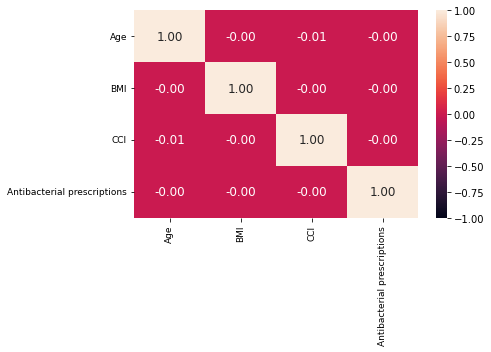

In [105]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_otmedia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_otmedia/corr_otmedia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [106]:
data_otmedia = data_otmedia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'otmedia_ab_date', 'ab_type_cat', 'incdt_otmedia_date', 'date', 'period',
                                   'event_otmedia_admitted', 'duration_otmedia_admitted'
                                    ]]

In [107]:
#switch variable otmedia_ab_date into a binary variable
data_otmedia[['ab_binary']] = data_otmedia[['otmedia_ab_date']].where(data_otmedia[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_otmedia_incdt = data_otmedia[data_otmedia['incdt_otmedia_date'] == 0]
data_otmedia_prevl = data_otmedia[data_otmedia['incdt_otmedia_date'] == 1]

#no antibiotics and incident hospital admission
data_otmedia_no_abs_incdt = data_otmedia_incdt[data_otmedia_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_otmedia_abs_incdt = data_otmedia_incdt[data_otmedia_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_otmedia_no_abs_prevl = data_otmedia_prevl[data_otmedia_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_otmedia_abs_prevl = data_otmedia_prevl[data_otmedia_prevl['ab_binary'] == 1]

In [108]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_otmedia_incdt_prepandemic = data_otmedia_incdt[data_otmedia_incdt['period'] == 'prepandemic']
data_otmedia_incdt_during_pandemic = data_otmedia_incdt[(data_otmedia_incdt['period'] == 'during_pandemic')]
data_otmedia_incdt_post_2nd_lockdown = data_otmedia_incdt[data_otmedia_incdt['period'] == 'post_2nd_lockdown']
data_otmedia_prevl_prepandemic = data_otmedia_prevl[data_otmedia_prevl['period'] == 'prepandemic']
data_otmedia_prevl_during_pandemic = data_otmedia_prevl[(data_otmedia_prevl['period'] == 'during_pandemic')]
data_otmedia_prevl_post_2nd_lockdown = data_otmedia_prevl[data_otmedia_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_otmedia_no_abs_incdt_prepandemic = data_otmedia_incdt_prepandemic[data_otmedia_incdt_prepandemic['ab_binary'] == 0]
data_otmedia_no_abs_incdt_during_pandemic = data_otmedia_incdt_during_pandemic[data_otmedia_incdt_during_pandemic['ab_binary'] == 0]
data_otmedia_no_abs_incdt_post_2nd_lockdown = data_otmedia_incdt_post_2nd_lockdown[data_otmedia_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_otmedia_no_abs_prevl_prepandemic = data_otmedia_prevl_prepandemic[data_otmedia_prevl_prepandemic['ab_binary'] == 0]
data_otmedia_no_abs_prevl_during_pandemic = data_otmedia_prevl_during_pandemic[data_otmedia_prevl_during_pandemic['ab_binary'] == 0]
data_otmedia_no_abs_prevl_post_2nd_lockdown = data_otmedia_prevl_post_2nd_lockdown[data_otmedia_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [109]:
#store data for plotting hosp admission counts and percentages
%store data_otmedia
# save data
data_otmedia.to_csv('../output/hospitalisation_prediction_otmedia/data_otmedia.csv')

Stored 'data_otmedia' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108667 total observations, 108006 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 108667
number of events observed = 661
   partial log-likelihood = -7649.63
         time fit was run = 2023-06-28 14:54:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.12            -0.27             0.19                 0.76                 1.21
CCI_cat[T.medium]                0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
CCI_cat[T.high]                  0.00       1.00       0.16            -0.30             0.31                 0.74                 1.36
CCI_cat[T.very_high]             0.12       1.13       0.13            -0.14             0.38                 0.87                 1.46
age_cat[T.25_34]                -0.07       0.93       0.14            -0.35             0.21                 0.70                 1.23
age_cat[T.35_44]                -0.01       0.99       0.14            -0.28             0.26                 0.75                 1.30
age_cat[T.45_54]                -0.13       0.88       0.15            -0.41             0.16                 0.66                 1.17
age_cat[T.55_64]                -0.14       0.87       0.15            -0.43             0.14                 0.65                 1.16
age_cat[T.65_74]                -0.12       0.89       0.14            -0.40             0.16                 0.67                 1.18
age_cat[T.75_more]              -0.07       0.93       0.14            -0.35             0.21                 0.71                 1.23
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.04                 0.94                 1.04
bmi_cat[T.obese]                 0.14       1.15       0.15            -0.16             0.44                 0.85                 1.55
bmi_cat[T.overweight]            0.16       1.17       0.18            -0.20             0.52                 0.82                 1.68
bmi_cat[T.underweight]           0.11       1.11       0.26            -0.40             0.61                 0.67                 1.85
bmi_cat[T.unknown]               0.06       1.06       0.16            -0.27             0.38                 0.77                 1.46
ethnicity[T.other]              -0.09       0.91       0.20            -0.49             0.31                 0.61                 1.36
ethnicity[T.unknown]             0.15       1.16       0.16            -0.16             0.46                 0.85                 1.58
ethnicity[T.white]              -0.05       0.95       0.15            -0.35             0.24                 0.70                 1.27
flu_vaccine[T.yes]              -0.05       0.95       0.13            -0.31             0.21                 0.74                 1.23
imd[T.medium]                   -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
imd[T.unaffluent]               -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
imd[T.unknown]                  -0.27       0.76       0.22            -0.70             0.16                 0.50                 1.17
imd[T.very_affluent]             0.06       1.06       0.13            -0.19             0.30                 0.83                 1.35
imd[T.very_unaffluent]           0.09       1.09       0.12            -0.15             0.33                 0.86                 1.39
region[T.east_midlands]         -0.11       0.90       0.17

13061


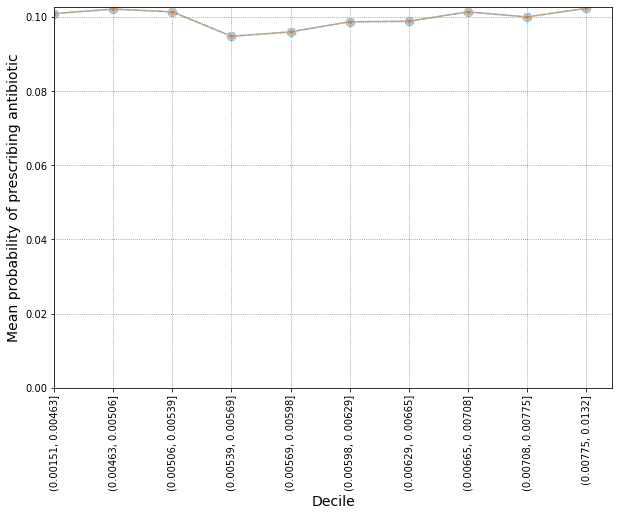


AUROC of LR for deciles with development and validation data: 0.50878 and 0.49659
AUROC of RF for deciles with development and validation data: 0.51886 and 0.49401
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00151, 0.00463]  0.114274  0.107405  0.121581
bins_(0.00463, 0.00506]  0.112530  0.105764  0.119730
bins_(0.00506, 0.00539]  0.109690  0.103052  0.116755
bins_(0.00539, 0.00569]  0.102428  0.096092  0.109182
bins_(0.00569, 0.00598]  0.106382  0.099900  0.113285
bins_(0.00598, 0.00629]  0.110343  0.103733  0.117375
bins_(0.00629, 0.00665]  0.110902  0.104266  0.117960
bins_(0.00665, 0.00708]  0.111720  0.105077  0.118783
bins_(0.00708, 0.00775]  0.113364  0.106689  0.120457
bins_(0.00775, 0.0132]   0.114746  0.108020  0.121892
antibacterial_brit       0.997789  0.984578  1.011177

RF feature importance:
                           rf_coef
antibacterial_brit       0.594739
bins_(0.00539, 0.00569]  0.086877
bins_(0.00708, 0.00775]  0.069880
bins_(0.

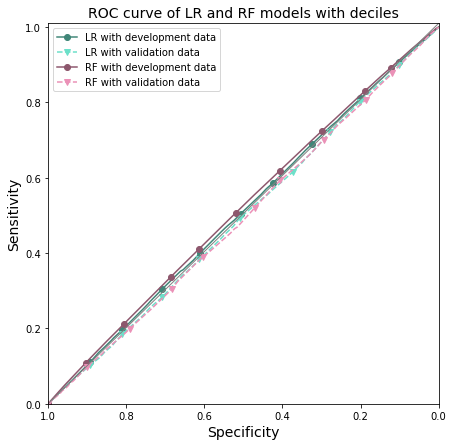

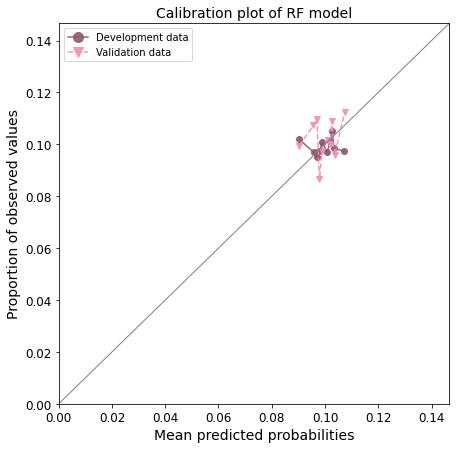

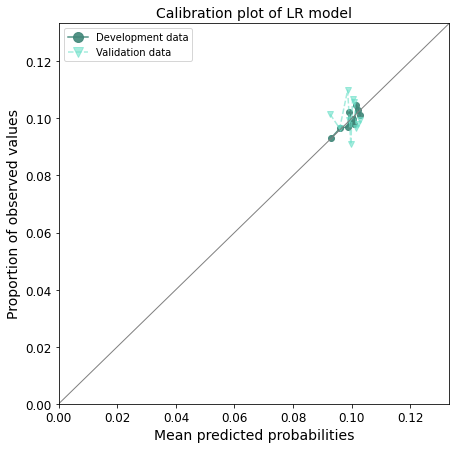


AUROC of LR for risk factors with development and validation data: 0.51680 and 0.51304
AUROC of RF for risk factors with development and validation data: 0.60267 and 0.51082
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.905190  0.000000       inf
age_cat_25_34                0.833446  0.000000       inf
age_cat_35_44                0.894404  0.000000       inf
age_cat_45_54                0.931395  0.000000       inf
age_cat_55_64                0.848236  0.000000       inf
age_cat_65_74                0.879838  0.000000       inf
age_cat_75_more              0.905802  0.000000       inf
sex_female                   0.634657       NaN       NaN
sex_male                     0.669419       NaN       NaN
CCI_cat_high                 0.820917  0.000000       inf
CCI_cat_low                  0.833537  0.000000       inf
CCI_cat_medium               0.828753  0.000000       inf
CCI_cat_very_high            0.842200  0.000000      

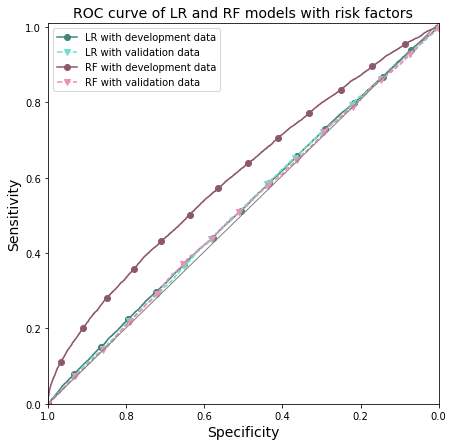

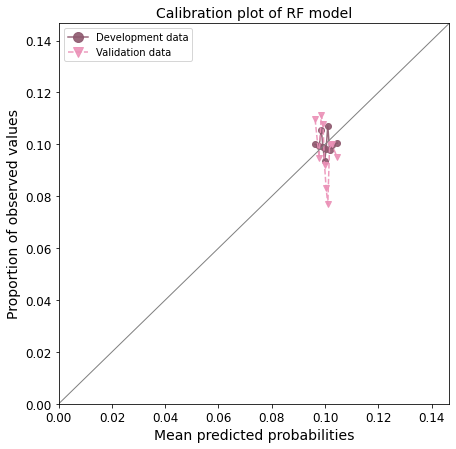

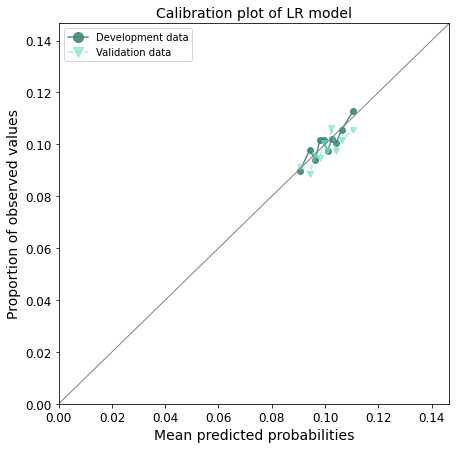

In [110]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_incdt, prob_pred_otmedia_no_abs_incdt_bin = cox_build('otmedia', 'incdt', data_otmedia_incdt, data_otmedia_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('otmedia', 'incdt_deciles', prob_pred_otmedia_no_abs_incdt)

#make summary table
make_summary_table('otmedia', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('otmedia', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('otmedia', 'incdt_riskfactors', prob_pred_otmedia_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('otmedia', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12003 total observations, 11922 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 12003
number of events observed = 81
   partial log-likelihood = -739.28
         time fit was run = 2023-06-28 14:56:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.30            -0.80             0.40                 0.45                 1.49
CCI_cat[T.medium]               -0.31       0.73       0.35            -1.00             0.37                 0.37                 1.45
CCI_cat[T.high]                 -0.32       0.73       0.43            -1.16             0.52                 0.31                 1.69
CCI_cat[T.very_high]            -0.58       0.56       0.40            -1.37             0.20                 0.25                 1.22
age_cat[T.25_34]                 0.61       1.85       0.56            -0.48             1.71                 0.62                 5.52
age_cat[T.35_44]                 0.85       2.34       0.54            -0.21             1.91                 0.81                 6.73
age_cat[T.45_54]                 1.21       3.34       0.51             0.20             2.21                 1.22                 9.14
age_cat[T.55_64]                 1.34       3.83       0.51             0.35             2.33                 1.42                10.32
age_cat[T.65_74]                 1.05       2.85       0.52             0.02             2.07                 1.02                 7.91
age_cat[T.75_more]               0.46       1.58       0.57            -0.66             1.58                 0.52                 4.84
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                 0.13       1.14       0.44            -0.73             0.99                 0.48                 2.68
bmi_cat[T.overweight]            0.22       1.24       0.52            -0.80             1.23                 0.45                 3.43
bmi_cat[T.underweight]           0.15       1.16       0.71            -1.24             1.54                 0.29                 4.67
bmi_cat[T.unknown]               0.01       1.01       0.47            -0.91             0.93                 0.40                 2.53
ethnicity[T.other]               0.22       1.25       0.56            -0.87             1.32                 0.42                 3.72
ethnicity[T.unknown]            -0.16       0.85       0.48            -1.09             0.77                 0.33                 2.16
ethnicity[T.white]               0.08       1.09       0.43            -0.76             0.93                 0.47                 2.53
flu_vaccine[T.yes]              -0.02       0.98       0.37            -0.75             0.71                 0.47                 2.04
imd[T.medium]                    0.39       1.47       0.35            -0.30             1.07                 0.74                 2.92
imd[T.unaffluent]               -0.14       0.87       0.39            -0.91             0.63                 0.40                 1.88
imd[T.unknown]                  -1.32       0.27       1.04            -3.35             0.71                 0.04                 2.03
imd[T.very_affluent]             0.41       1.51       0.35            -0.27             1.09                 0.76                 2.99
imd[T.very_unaffluent]           0.00       1.00       0.38            -0.74             0.75                 0.48                 2.11
region[T.east_midlands]          0.72       2.06       0.55     

13034


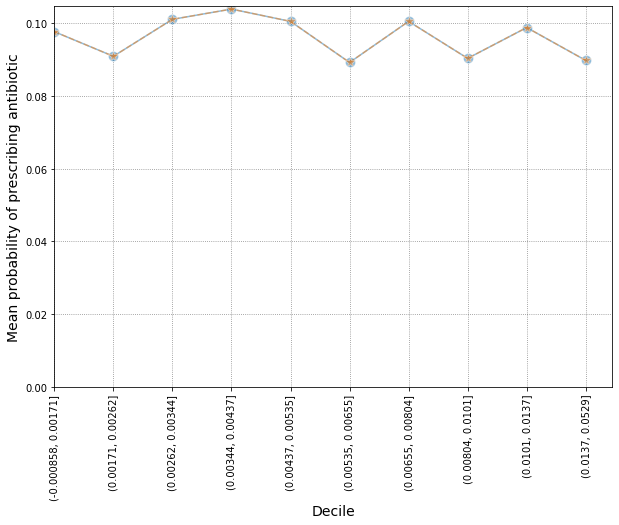


AUROC of LR for deciles with development and validation data: 0.52329 and 0.48403
AUROC of RF for deciles with development and validation data: 0.54899 and 0.49027
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000858, 0.00171]  0.102562  0.084821  0.124013
bins_(0.00171, 0.00262]    0.098789  0.081627  0.119559
bins_(0.00262, 0.00344]    0.114617  0.095603  0.137413
bins_(0.00344, 0.00437]    0.118144  0.098505  0.141699
bins_(0.00437, 0.00535]    0.121014  0.100937  0.145083
bins_(0.00535, 0.00655]    0.095960  0.078746  0.116936
bins_(0.00655, 0.00804]    0.098728  0.081139  0.120130
bins_(0.00804, 0.0101]     0.103154  0.085102  0.125034
bins_(0.0101, 0.0137]      0.110951  0.091777  0.134131
bins_(0.0137, 0.0529]      0.097361  0.079578  0.119118
antibacterial_brit         0.996867  0.956715  1.038703

RF feature importance:
                             rf_coef
antibacterial_brit         0.628480
bins_(0.00344, 0.00437]    0.059972
bins_(0.0043

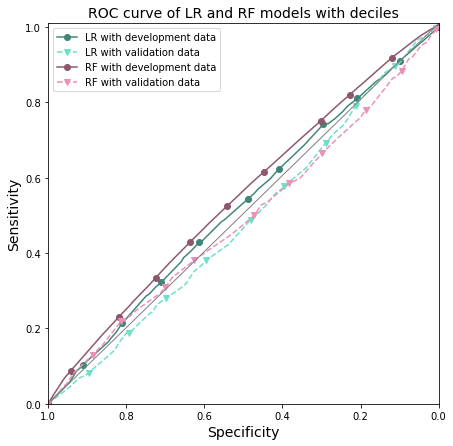

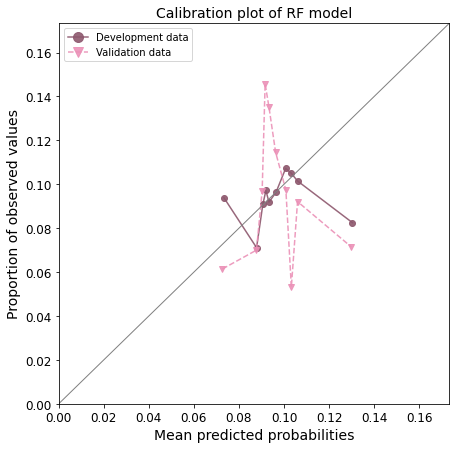

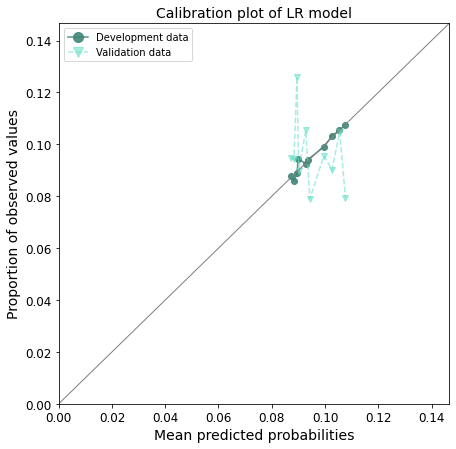


AUROC of LR for risk factors with development and validation data: 0.55386 and 0.50102
AUROC of RF for risk factors with development and validation data: 0.81810 and 0.49614
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.851834  0.000000       inf
age_cat_25_34                0.834488  0.000000       inf
age_cat_35_44                0.961063  0.000000       inf
age_cat_45_54                0.801940  0.000000       inf
age_cat_55_64                0.882305  0.000000       inf
age_cat_65_74                0.831938  0.000000       inf
age_cat_75_more              1.016786  0.000000       inf
sex_female                   0.619794  0.000000       inf
sex_male                     0.659722  0.000000       inf
CCI_cat_high                 0.898667  0.000000       inf
CCI_cat_low                  0.782700  0.000000       inf
CCI_cat_medium               0.884049  0.000000       inf
CCI_cat_very_high            0.798492  0.000000      

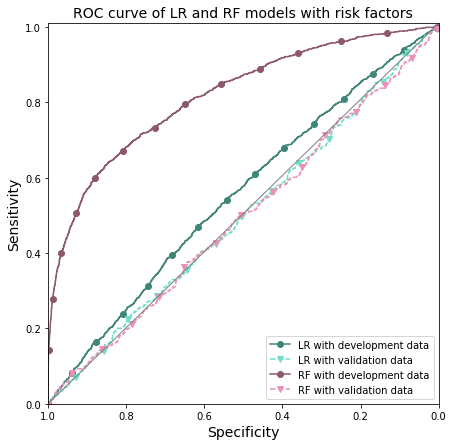

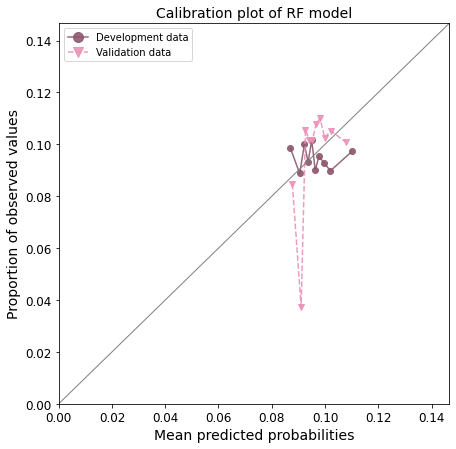

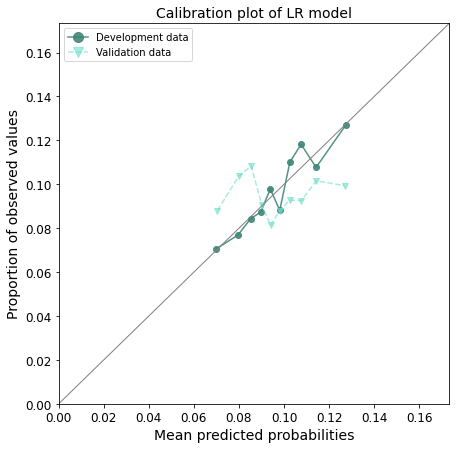

In [111]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_prevl, prob_pred_otmedia_no_abs_prevl_bin = cox_build('otmedia', 'prevl', data_otmedia_prevl, data_otmedia_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('otmedia', 'prevl_deciles', prob_pred_otmedia_no_abs_prevl)

#make summary table
make_summary_table('otmedia', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('otmedia', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('otmedia', 'prevl_riskfactors', prob_pred_otmedia_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('otmedia', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28572 total observations, 28394 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 28572
number of events observed = 178
   partial log-likelihood = -1806.13
         time fit was run = 2023-06-28 14:57:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.23            -0.50             0.42                 0.61                 1.53
CCI_cat[T.medium]                0.37       1.45       0.24            -0.10             0.84                 0.90                 2.31
CCI_cat[T.high]                  0.28       1.32       0.29            -0.29             0.84                 0.75                 2.32
CCI_cat[T.very_high]            -0.10       0.90       0.28            -0.65             0.45                 0.52                 1.56
age_cat[T.25_34]                -0.15       0.86       0.26            -0.66             0.37                 0.52                 1.45
age_cat[T.35_44]                -0.47       0.62       0.29            -1.04             0.09                 0.35                 1.09
age_cat[T.45_54]                -0.42       0.66       0.29            -0.98             0.15                 0.38                 1.16
age_cat[T.55_64]                -0.06       0.95       0.26            -0.56             0.45                 0.57                 1.56
age_cat[T.65_74]                -0.29       0.75       0.28            -0.83             0.25                 0.43                 1.28
age_cat[T.75_more]              -0.17       0.84       0.26            -0.69             0.34                 0.50                 1.41
antibacterial_brit               0.07       1.07       0.05            -0.04             0.17                 0.96                 1.18
bmi_cat[T.obese]                 0.15       1.16       0.29            -0.41             0.71                 0.66                 2.03
bmi_cat[T.overweight]            0.00       1.00       0.36            -0.70             0.70                 0.50                 2.02
bmi_cat[T.underweight]           0.27       1.31       0.46            -0.64             1.18                 0.53                 3.25
bmi_cat[T.unknown]              -0.09       0.92       0.31            -0.70             0.52                 0.50                 1.69
ethnicity[T.other]              -0.20       0.82       0.36            -0.90             0.50                 0.41                 1.65
ethnicity[T.unknown]            -0.09       0.91       0.27            -0.63             0.44                 0.53                 1.56
ethnicity[T.white]              -0.40       0.67       0.26            -0.90             0.11                 0.41                 1.12
flu_vaccine[T.yes]               0.34       1.40       0.22            -0.09             0.77                 0.91                 2.16
imd[T.medium]                   -0.11       0.89       0.27            -0.64             0.42                 0.53                 1.52
imd[T.unaffluent]               -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.66
imd[T.unknown]                  -0.11       0.89       0.42            -0.94             0.71                 0.39                 2.04
imd[T.very_affluent]             0.35       1.42       0.24            -0.13             0.82                 0.88                 2.27
imd[T.very_unaffluent]           0.42       1.52       0.24            -0.05             0.89                 0.95                 2.43
region[T.east_midlands]          0.03       1.03       0.32   

13054


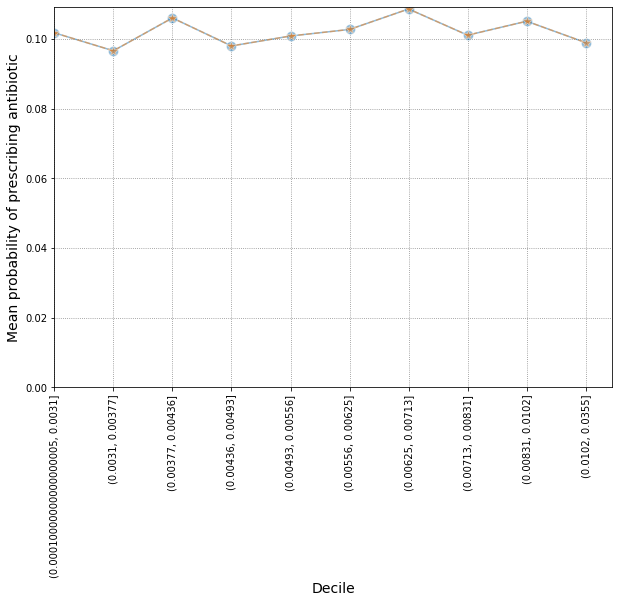


AUROC of LR for deciles with development and validation data: 0.51441 and 0.50247
AUROC of RF for deciles with development and validation data: 0.52791 and 0.49557
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.00010000000000000005, 0.0031]  0.116098  0.103473  0.130264
bins_(0.0031, 0.00377]                 0.103909  0.092103  0.117227
bins_(0.00377, 0.00436]                0.121205  0.108020  0.135999
bins_(0.00436, 0.00493]                0.109238  0.096888  0.123162
bins_(0.00493, 0.00556]                0.112260  0.099643  0.126475
bins_(0.00556, 0.00625]                0.118002  0.104978  0.132641
bins_(0.00625, 0.00713]                0.121385  0.108013  0.136414
bins_(0.00713, 0.00831]                0.114201  0.101191  0.128884
bins_(0.00831, 0.0102]                 0.114814  0.101702  0.129617
bins_(0.0102, 0.0355]                  0.107313  0.094655  0.121664
antibacterial_brit                     1.005774  0.980024  1.032200



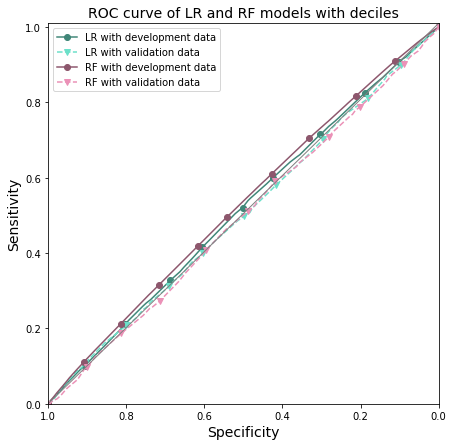

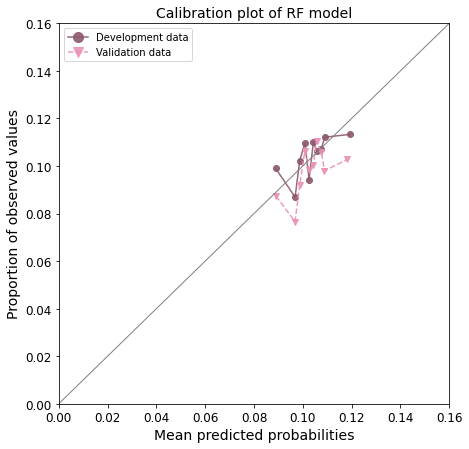

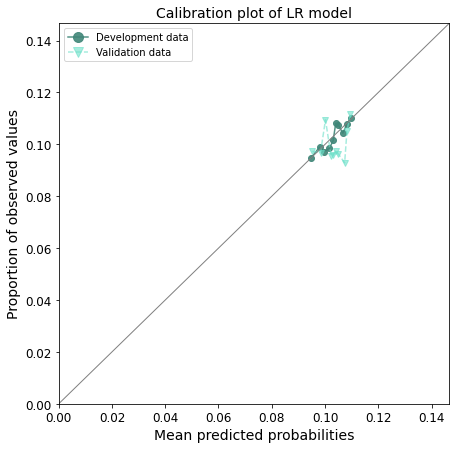

In [112]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_incdt_prepandemic, prob_pred_otmedia_no_abs_incdt_prepandemic_bin = cox_build('otmedia', 'incdt_prepandemic', data_otmedia_incdt_prepandemic, data_otmedia_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('otmedia', 'incdt_prepandemic', prob_pred_otmedia_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33462 total observations, 33254 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 33462
number of events observed = 208
   partial log-likelihood = -2152.21
         time fit was run = 2023-06-28 14:57:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.08       0.22            -0.36             0.51                 0.70                 1.67
CCI_cat[T.medium]                0.04       1.04       0.24            -0.44             0.51                 0.64                 1.67
CCI_cat[T.high]                  0.24       1.27       0.28            -0.30             0.78                 0.74                 2.19
CCI_cat[T.very_high]             0.40       1.48       0.24            -0.07             0.86                 0.93                 2.37
age_cat[T.25_34]                -0.06       0.94       0.25            -0.56             0.43                 0.57                 1.54
age_cat[T.35_44]                 0.02       1.02       0.25            -0.47             0.50                 0.63                 1.65
age_cat[T.45_54]                -0.13       0.88       0.25            -0.63             0.37                 0.53                 1.44
age_cat[T.55_64]                -0.18       0.84       0.26            -0.69             0.33                 0.50                 1.39
age_cat[T.65_74]                -0.18       0.84       0.26            -0.69             0.33                 0.50                 1.39
age_cat[T.75_more]              -0.12       0.88       0.25            -0.62             0.38                 0.54                 1.46
antibacterial_brit              -0.10       0.91       0.05            -0.20             0.00                 0.82                 1.00
bmi_cat[T.obese]                 0.35       1.42       0.29            -0.22             0.92                 0.80                 2.52
bmi_cat[T.overweight]            0.30       1.35       0.34            -0.38             0.97                 0.68                 2.64
bmi_cat[T.underweight]          -0.08       0.92       0.53            -1.12             0.95                 0.33                 2.58
bmi_cat[T.unknown]               0.24       1.27       0.31            -0.37             0.85                 0.69                 2.35
ethnicity[T.other]               0.47       1.61       0.38            -0.28             1.22                 0.76                 3.40
ethnicity[T.unknown]             0.48       1.62       0.33            -0.16             1.12                 0.85                 3.07
ethnicity[T.white]               0.31       1.37       0.32            -0.30             0.93                 0.74                 2.54
flu_vaccine[T.yes]              -0.07       0.93       0.24            -0.53             0.39                 0.59                 1.48
imd[T.medium]                    0.08       1.08       0.23            -0.37             0.52                 0.69                 1.69
imd[T.unaffluent]                0.12       1.13       0.22            -0.32             0.56                 0.73                 1.75
imd[T.unknown]                  -0.18       0.84       0.39            -0.94             0.59                 0.39                 1.80
imd[T.very_affluent]            -0.13       0.88       0.24            -0.60             0.34                 0.55                 1.41
imd[T.very_unaffluent]           0.21       1.23       0.22            -0.23             0.64                 0.80                 1.89
region[T.east_midlands]         -0.16       0.86       0.31   

13050


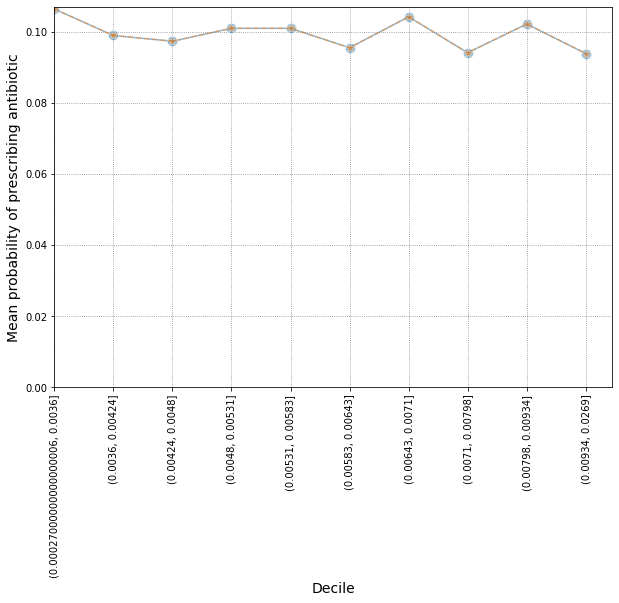


AUROC of LR for deciles with development and validation data: 0.51862 and 0.49987
AUROC of RF for deciles with development and validation data: 0.52941 and 0.50175
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.00027000000000000006, 0.0036]  0.113587  0.100740  0.128072
bins_(0.0036, 0.00424]                 0.105998  0.094176  0.119303
bins_(0.00424, 0.0048]                 0.101262  0.089976  0.113964
bins_(0.0048, 0.00531]                 0.111944  0.100026  0.125282
bins_(0.00531, 0.00583]                0.109450  0.097916  0.122341
bins_(0.00583, 0.00643]                0.101171  0.090196  0.113481
bins_(0.00643, 0.0071]                 0.112313  0.100726  0.125233
bins_(0.0071, 0.00798]                 0.101303  0.090518  0.113373
bins_(0.00798, 0.00934]                0.116678  0.104962  0.129702
bins_(0.00934, 0.0269]                 0.098919  0.088400  0.110691
antibacterial_brit                     1.018070  0.992264  1.044548



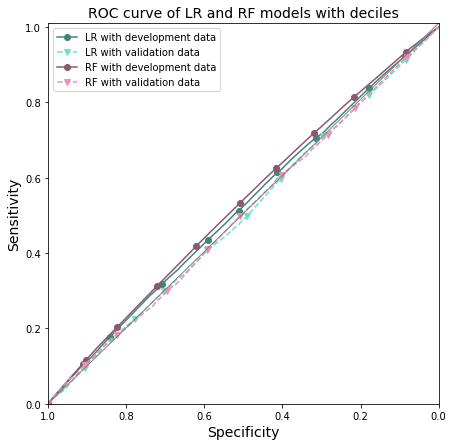

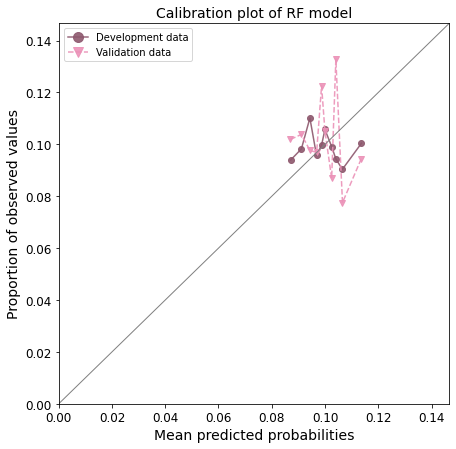

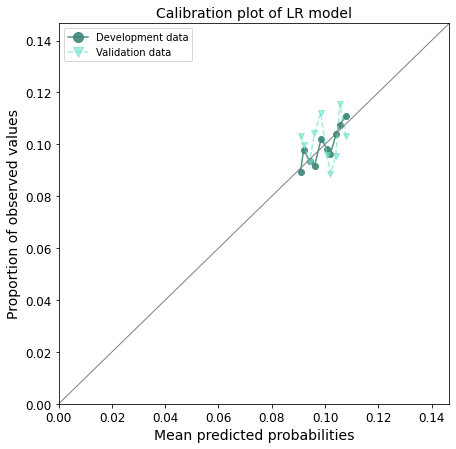

In [113]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_incdt_during_pandemic, prob_pred_otmedia_no_abs_incdt_during_pandemic_bin = cox_build('otmedia', 'incdt_during_pandemic', data_otmedia_incdt_during_pandemic, data_otmedia_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('otmedia', 'incdt_during_pandemic', prob_pred_otmedia_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46632 total observations, 46310 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 46632
number of events observed = 322
   partial log-likelihood = -3444.78
         time fit was run = 2023-06-28 14:57:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
CCI_cat[T.medium]               -0.05       0.95       0.18            -0.39             0.30                 0.67                 1.35
CCI_cat[T.high]                 -0.18       0.83       0.22            -0.62             0.25                 0.54                 1.29
CCI_cat[T.very_high]            -0.09       0.92       0.19            -0.46             0.28                 0.63                 1.32
age_cat[T.25_34]                 0.00       1.00       0.21            -0.40             0.40                 0.67                 1.50
age_cat[T.35_44]                 0.02       1.02       0.20            -0.38             0.42                 0.68                 1.52
age_cat[T.45_54]                 0.08       1.08       0.20            -0.32             0.48                 0.73                 1.61
age_cat[T.55_64]                -0.09       0.91       0.21            -0.50             0.32                 0.60                 1.38
age_cat[T.65_74]                -0.00       1.00       0.21            -0.40             0.40                 0.67                 1.49
age_cat[T.75_more]              -0.17       0.85       0.21            -0.59             0.25                 0.56                 1.29
antibacterial_brit              -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
bmi_cat[T.obese]                 0.05       1.05       0.21            -0.37             0.47                 0.69                 1.60
bmi_cat[T.overweight]           -0.13       0.87       0.27            -0.66             0.39                 0.52                 1.48
bmi_cat[T.underweight]           0.25       1.29       0.34            -0.42             0.93                 0.66                 2.52
bmi_cat[T.unknown]              -0.05       0.96       0.23            -0.50             0.41                 0.61                 1.50
ethnicity[T.other]              -0.03       0.97       0.29            -0.59             0.53                 0.55                 1.70
ethnicity[T.unknown]             0.09       1.10       0.23            -0.35             0.54                 0.70                 1.71
ethnicity[T.white]              -0.08       0.93       0.21            -0.49             0.34                 0.61                 1.41
flu_vaccine[T.yes]              -0.28       0.76       0.21            -0.69             0.13                 0.50                 1.14
imd[T.medium]                    0.14       1.15       0.18            -0.21             0.49                 0.81                 1.64
imd[T.unaffluent]               -0.08       0.93       0.19            -0.44             0.29                 0.64                 1.34
imd[T.unknown]                  -0.26       0.77       0.32            -0.88             0.36                 0.41                 1.43
imd[T.very_affluent]             0.15       1.16       0.18            -0.20             0.50                 0.82                 1.64
imd[T.very_unaffluent]           0.03       1.03       0.18            -0.33             0.39                 0.72                 1.47
region[T.east_midlands]         -0.64       0.52       0.26   

13071


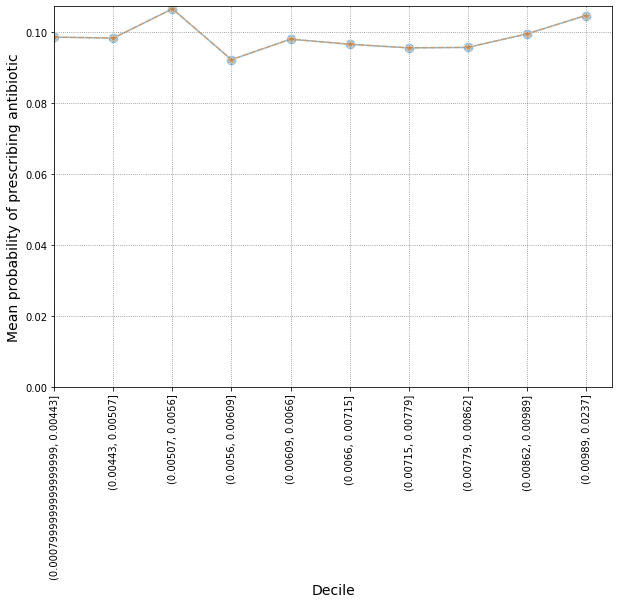


AUROC of LR for deciles with development and validation data: 0.51594 and 0.50099
AUROC of RF for deciles with development and validation data: 0.53175 and 0.50723
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0007999999999999999, 0.00443]  0.107102  0.097057  0.118187
bins_(0.00443, 0.00507]                0.109460  0.099354  0.120594
bins_(0.00507, 0.0056]                 0.116811  0.106316  0.128341
bins_(0.0056, 0.00609]                 0.101613  0.092078  0.112134
bins_(0.00609, 0.0066]                 0.114456  0.104248  0.125664
bins_(0.0066, 0.00715]                 0.102042  0.092529  0.112532
bins_(0.00715, 0.00779]                0.104174  0.094629  0.114681
bins_(0.00779, 0.00862]                0.107194  0.097462  0.117897
bins_(0.00862, 0.00989]                0.114195  0.104154  0.125205
bins_(0.00989, 0.0237]                 0.118242  0.107955  0.129508
antibacterial_brit                     0.991267  0.970939  1.012021



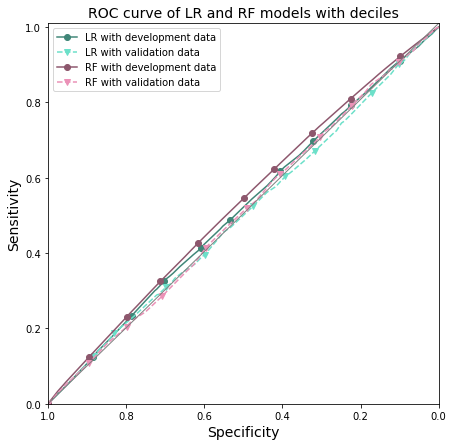

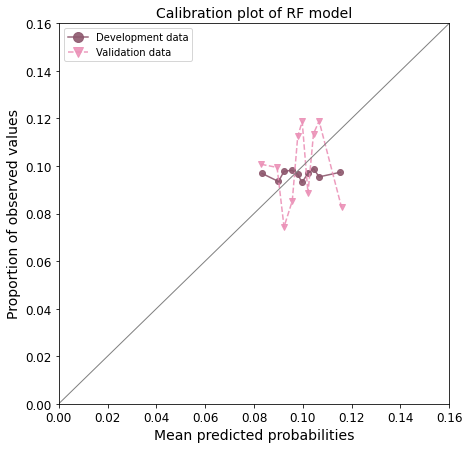

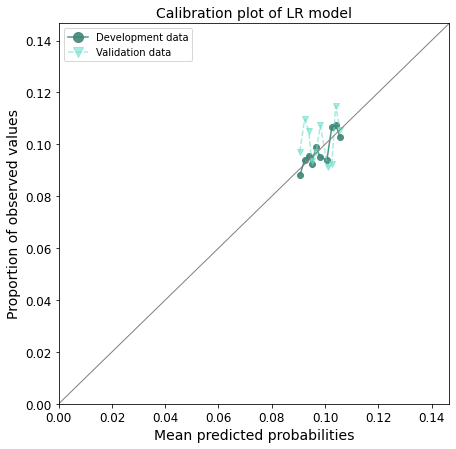

In [114]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_incdt_post_2nd_lockdown, prob_pred_otmedia_no_abs_incdt_post_2nd_lockdown_bin = cox_build('otmedia', 'incdt_post_2nd_lockdown', data_otmedia_incdt_post_2nd_lockdown, data_otmedia_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('otmedia', 'incdt_post_2nd_lockdown', prob_pred_otmedia_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3225 total observations, 3202 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 3225
number of events observed = 23
   partial log-likelihood = -170.00
         time fit was run = 2023-06-28 14:58:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.60            -0.99             1.35                 0.37                 3.87
CCI_cat[T.medium]               -0.11       0.89       0.72            -1.52             1.29                 0.22                 3.63
CCI_cat[T.high]                 -0.23       0.80       0.88            -1.95             1.49                 0.14                 4.45
CCI_cat[T.very_high]            -0.20       0.82       0.77            -1.71             1.32                 0.18                 3.73
age_cat[T.25_34]                -1.23       0.29       1.16            -3.51             1.05                 0.03                 2.85
age_cat[T.35_44]                -0.03       0.98       0.82            -1.64             1.59                 0.19                 4.89
age_cat[T.45_54]                 0.69       1.98       0.70            -0.68             2.05                 0.51                 7.77
age_cat[T.55_64]                 0.55       1.74       0.74            -0.90             2.00                 0.41                 7.41
age_cat[T.65_74]                -0.65       0.52       0.92            -2.45             1.15                 0.09                 3.17
age_cat[T.75_more]              -0.58       0.56       0.92            -2.38             1.23                 0.09                 3.41
antibacterial_brit              -0.12       0.88       0.16            -0.43             0.18                 0.65                 1.20
bmi_cat[T.obese]                 0.65       1.92       1.05            -1.40             2.71                 0.25                14.97
bmi_cat[T.overweight]           -0.24       0.79       1.42            -3.02             2.55                 0.05                12.78
bmi_cat[T.underweight]           1.81       6.08       1.25            -0.64             4.26                 0.52                70.54
bmi_cat[T.unknown]               0.94       2.56       1.08            -1.18             3.05                 0.31                21.18
ethnicity[T.other]               0.71       2.04       1.25            -1.73             3.16                 0.18                23.47
ethnicity[T.unknown]             0.12       1.13       1.13            -2.09             2.33                 0.12                10.30
ethnicity[T.white]               0.60       1.83       1.04            -1.44             2.65                 0.24                14.15
flu_vaccine[T.yes]              -0.18       0.84       0.76            -1.66             1.30                 0.19                 3.68
imd[T.medium]                    0.18       1.19       0.62            -1.04             1.39                 0.36                 4.00
imd[T.unaffluent]               -1.04       0.36       0.85            -2.69             0.62                 0.07                 1.87
imd[T.unknown]                  -0.38       0.68       1.11            -2.57             1.80                 0.08                 6.05
imd[T.very_affluent]             0.25       1.28       0.61            -0.96             1.45                 0.38                 4.27
imd[T.very_unaffluent]          -0.63       0.53       0.74            -2.09             0.82                 0.12                 2.28
region[T.east_midlands]         -0.64       0.52       0.93        

13059


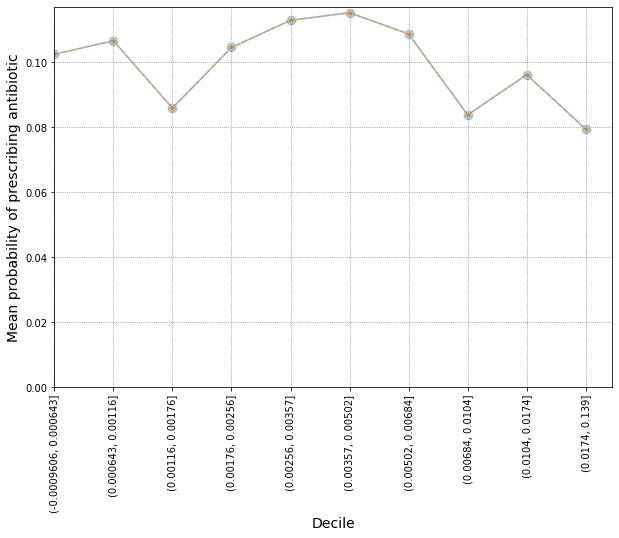


AUROC of LR for deciles with development and validation data: 0.52423 and 0.54375
AUROC of RF for deciles with development and validation data: 0.58941 and 0.52252
LR coefficients:
                                    OR  Lower CI  Upper CI
bins_(-0.0009606, 0.000643]  0.100490  0.068411  0.147611
bins_(0.000643, 0.00116]     0.114014  0.079695  0.163112
bins_(0.00116, 0.00176]      0.110554  0.076916  0.158901
bins_(0.00176, 0.00256]      0.113353  0.079219  0.162195
bins_(0.00256, 0.00357]      0.127552  0.090495  0.179785
bins_(0.00357, 0.00502]      0.127818  0.091461  0.178628
bins_(0.00502, 0.00684]      0.120016  0.084719  0.170018
bins_(0.00684, 0.0104]       0.098574  0.067863  0.143183
bins_(0.0104, 0.0174]        0.108223  0.076013  0.154082
bins_(0.0174, 0.139]         0.102006  0.070420  0.147760
antibacterial_brit           0.998978  0.924205  1.079800

RF feature importance:
                               rf_coef
antibacterial_brit           0.632643
bins_(0.00357, 0.005

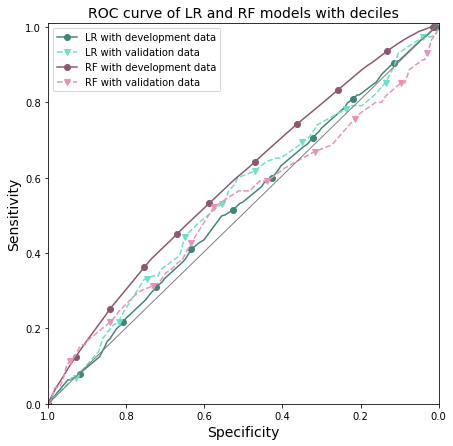

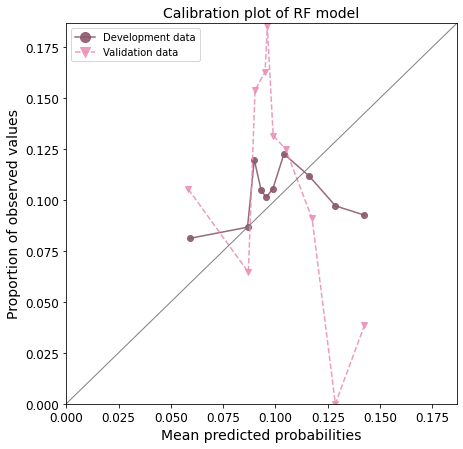

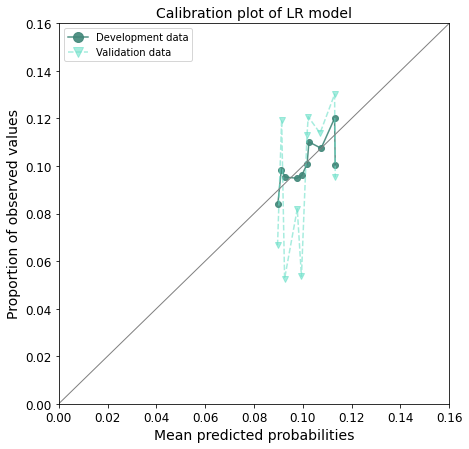

In [115]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_prevl_prepandemic, prob_pred_otmedia_no_abs_prevl_prepandemic_bin = cox_build('otmedia', 'prevl_prepandemic', data_otmedia_prevl_prepandemic, data_otmedia_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('otmedia', 'prevl_prepandemic', prob_pred_otmedia_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3681 total observations, 3652 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 3681
number of events observed = 29
   partial log-likelihood = -211.47
         time fit was run = 2023-06-28 14:58:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.57            -1.41             0.82                 0.24                 2.27
CCI_cat[T.medium]               -0.59       0.55       0.68            -1.92             0.73                 0.15                 2.07
CCI_cat[T.high]                  0.06       1.06       0.69            -1.29             1.40                 0.28                 4.05
CCI_cat[T.very_high]             0.39       1.48       0.60            -0.78             1.56                 0.46                 4.77
age_cat[T.25_34]                -1.10       0.33       1.16            -3.37             1.17                 0.03                 3.21
age_cat[T.35_44]                 0.15       1.17       0.82            -1.46             1.77                 0.23                 5.84
age_cat[T.45_54]                 1.30       3.68       0.67            -0.00             2.61                 1.00                13.56
age_cat[T.55_64]                -0.45       0.64       0.92            -2.25             1.34                 0.11                 3.84
age_cat[T.65_74]                 0.06       1.06       0.82            -1.55             1.66                 0.21                 5.29
age_cat[T.75_more]               0.87       2.39       0.70            -0.50             2.24                 0.61                 9.43
antibacterial_brit               0.09       1.10       0.13            -0.17             0.35                 0.85                 1.42
bmi_cat[T.obese]                -0.72       0.49       0.58            -1.86             0.42                 0.16                 1.53
bmi_cat[T.overweight]           -0.22       0.80       0.72            -1.63             1.18                 0.20                 3.25
bmi_cat[T.underweight]           0.61       1.84       0.79            -0.94             2.16                 0.39                 8.68
bmi_cat[T.unknown]              -0.94       0.39       0.68            -2.27             0.39                 0.10                 1.48
ethnicity[T.other]              -0.20       0.82       0.94            -2.04             1.64                 0.13                 5.14
ethnicity[T.unknown]            -0.15       0.86       0.71            -1.54             1.23                 0.22                 3.41
ethnicity[T.white]              -0.23       0.79       0.64            -1.49             1.02                 0.23                 2.77
flu_vaccine[T.yes]               0.23       1.26       0.55            -0.85             1.31                 0.43                 3.72
imd[T.medium]                   -0.90       0.41       0.62            -2.12             0.32                 0.12                 1.38
imd[T.unaffluent]               -0.48       0.62       0.58            -1.61             0.66                 0.20                 1.94
imd[T.unknown]                 -17.29       0.00    3918.08         -7696.59          7662.01                 0.00                  inf
imd[T.very_affluent]            -0.19       0.83       0.55            -1.26             0.88                 0.28                 2.41
imd[T.very_unaffluent]          -0.24       0.79       0.55            -1.31             0.83                 0.27                 2.30
region[T.east_midlands]          1.17       3.24       1.16        

13077


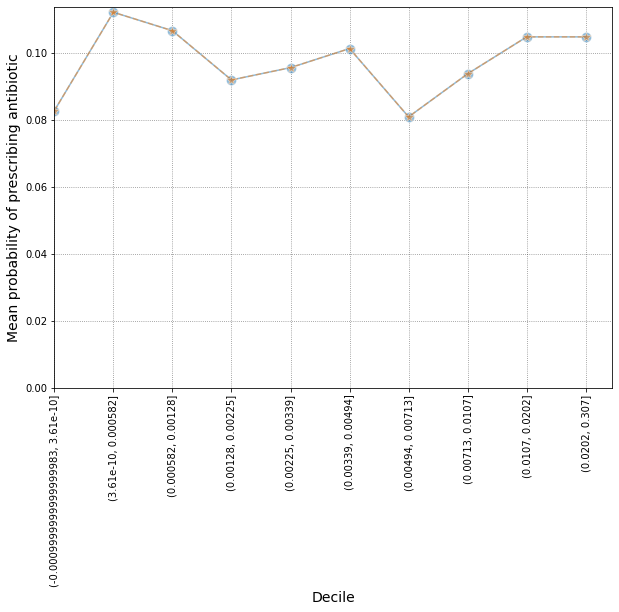


AUROC of LR for deciles with development and validation data: 0.54573 and 0.47650
AUROC of RF for deciles with development and validation data: 0.58839 and 0.51050
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.0009999999999999983, 3.61e-10]  0.088145  0.061439  0.126461
bins_(0.000582, 0.00128]                 0.109716  0.078542  0.153261
bins_(0.00128, 0.00225]                  0.082814  0.056732  0.120886
bins_(0.00225, 0.00339]                  0.096397  0.068034  0.136583
bins_(0.00339, 0.00494]                  0.119128  0.085660  0.165671
bins_(0.00494, 0.00713]                  0.089817  0.062437  0.129203
bins_(0.00713, 0.0107]                   0.094142  0.066070  0.134143
bins_(0.0107, 0.0202]                    0.114715  0.082570  0.159375
bins_(0.0202, 0.307]                     0.112627  0.080740  0.157108
bins_(3.61e-10, 0.000582]                0.139513  0.103009  0.188953
antibacterial_brit                       1.0201

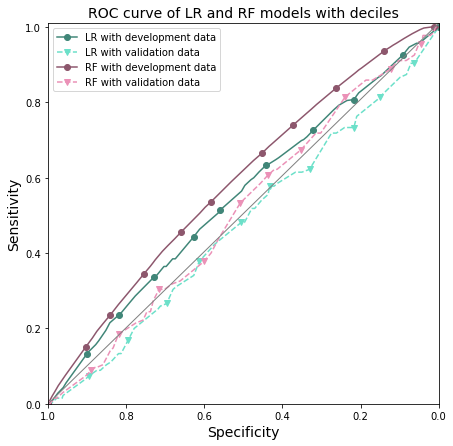

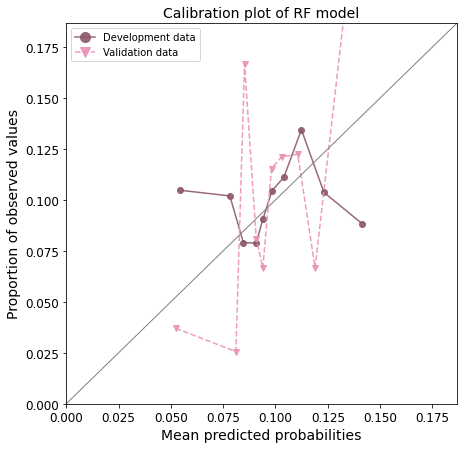

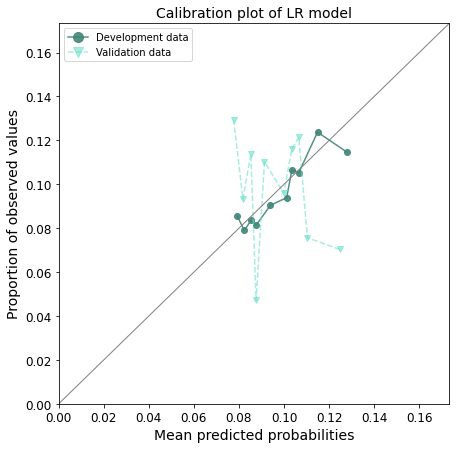

In [116]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_prevl_during_pandemic, prob_pred_otmedia_no_abs_prevl_during_pandemic_bin = cox_build('otmedia', 'prevl_during_pandemic', data_otmedia_prevl_during_pandemic, data_otmedia_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('otmedia', 'prevl_during_pandemic', prob_pred_otmedia_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5096 total observations, 5063 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 5096
number of events observed = 33
   partial log-likelihood = -247.76
         time fit was run = 2023-06-28 14:58:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.55            -0.92             1.22                 0.40                 3.40
CCI_cat[T.medium]                0.74       2.10       0.55            -0.34             1.83                 0.71                 6.21
CCI_cat[T.high]                  0.46       1.58       0.68            -0.87             1.79                 0.42                 5.99
CCI_cat[T.very_high]            -0.97       0.38       0.84            -2.62             0.68                 0.07                 1.98
age_cat[T.25_34]                 0.83       2.30       0.87            -0.88             2.54                 0.42                12.69
age_cat[T.35_44]                 1.29       3.64       0.83            -0.33             2.91                 0.72                18.34
age_cat[T.45_54]                -0.68       0.51       1.23            -3.09             1.73                 0.05                 5.62
age_cat[T.55_64]                 1.69       5.43       0.79             0.15             3.23                 1.16                25.31
age_cat[T.65_74]                 1.33       3.80       0.81            -0.25             2.92                 0.78                18.57
age_cat[T.75_more]               0.33       1.39       0.92            -1.47             2.14                 0.23                 8.47
antibacterial_brit               0.29       1.34       0.12             0.06             0.52                 1.06                 1.69
bmi_cat[T.obese]                 0.54       1.72       0.75            -0.93             2.02                 0.39                 7.53
bmi_cat[T.overweight]            0.98       2.65       0.83            -0.65             2.60                 0.52                13.49
bmi_cat[T.underweight]           0.07       1.07       1.24            -2.36             2.49                 0.09                12.07
bmi_cat[T.unknown]              -0.11       0.90       0.84            -1.76             1.55                 0.17                 4.71
ethnicity[T.other]              -0.85       0.43       0.85            -2.51             0.81                 0.08                 2.24
ethnicity[T.unknown]            -0.70       0.50       0.57            -1.82             0.42                 0.16                 1.52
ethnicity[T.white]              -0.93       0.39       0.52            -1.95             0.09                 0.14                 1.09
flu_vaccine[T.yes]              -0.72       0.49       0.74            -2.16             0.73                 0.12                 2.07
imd[T.medium]                    1.00       2.73       0.68            -0.33             2.34                 0.72                10.37
imd[T.unaffluent]                0.74       2.09       0.71            -0.66             2.13                 0.52                 8.44
imd[T.unknown]                   0.24       1.27       1.16            -2.04             2.51                 0.13                12.33
imd[T.very_affluent]             1.32       3.74       0.66             0.02             2.62                 1.02                13.71
imd[T.very_unaffluent]           0.63       1.89       0.73            -0.80             2.07                 0.45                 7.94
region[T.east_midlands]         19.00   1.78e+08    4309.19        

13132


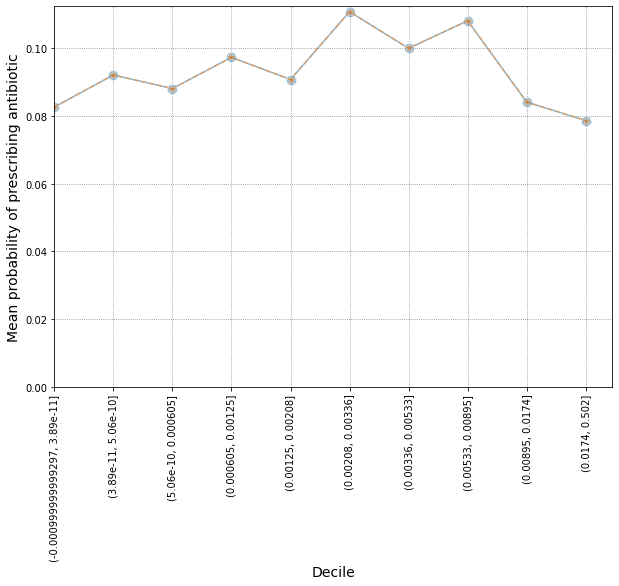


AUROC of LR for deciles with development and validation data: 0.54164 and 0.50758
AUROC of RF for deciles with development and validation data: 0.59236 and 0.50985
LR coefficients:
                                            OR  Lower CI  Upper CI
bins_(-0.000999999999297, 3.89e-11]  0.094469  0.069769  0.127913
bins_(0.000605, 0.00125]             0.111078  0.083628  0.147537
bins_(0.00125, 0.00208]              0.112352  0.084608  0.149192
bins_(0.00208, 0.00336]              0.132798  0.101308  0.174076
bins_(0.00336, 0.00533]              0.120183  0.090850  0.158988
bins_(0.00533, 0.00895]              0.131232  0.099580  0.172943
bins_(0.00895, 0.0174]               0.100747  0.074510  0.136221
bins_(0.0174, 0.502]                 0.078509  0.055658  0.110740
bins_(3.89e-11, 5.06e-10]            0.100352  0.073902  0.136268
bins_(5.06e-10, 0.000605]            0.105091  0.078826  0.140107
antibacterial_brit                   0.990947  0.928550  1.057536

RF feature importance:
 

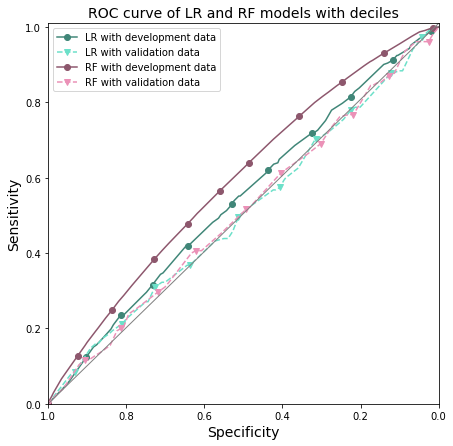

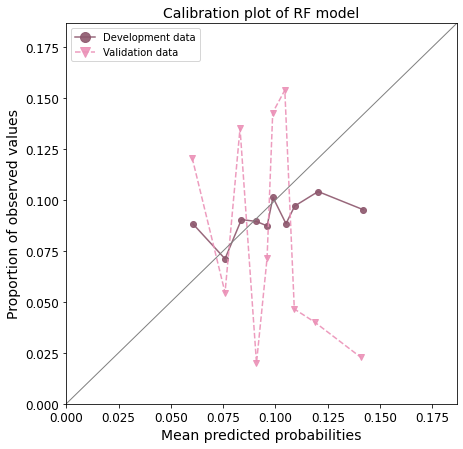

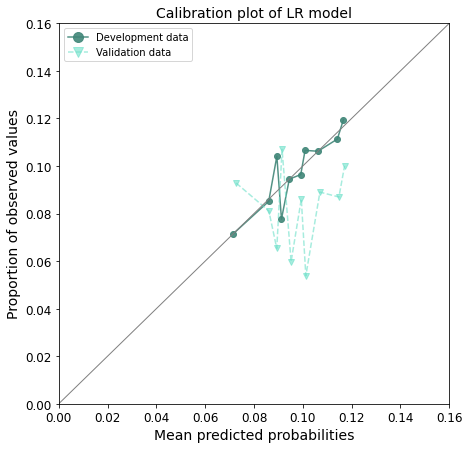

In [117]:
#build cox model for hosp prediction using non ab users' data
prob_pred_otmedia_no_abs_prevl_post_2nd_lockdown, prob_pred_otmedia_no_abs_prevl_post_2nd_lockdown_bin = cox_build('otmedia', 'prevl_post_2nd_lockdown', data_otmedia_prevl_post_2nd_lockdown, data_otmedia_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('otmedia', 'prevl_post_2nd_lockdown', prob_pred_otmedia_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('otmedia', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)